In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tools.data_loading import get_lincs, get_sirna_screen
from tools.genedisco_datasets import get_crispri_il2_screen


# Data Loading

In [2]:
lincs, lincs_genes, cell_lines = get_lincs()

Pulling folder parsed/literature_datasets/L1000
Pulling folder parsed/proteins


In [3]:
lincs.shape # num KOs X num transcripts X num cell lines

(5002, 978, 9)

In [6]:
sirna = get_sirna_screen()

Pulling folder parsed/literature_datasets/Muller_HCI-siRNA


## Loading up DEG contingency data

In [7]:
dists = {}
for ntype in ['real','shuffled']:
    dists[ntype] = {}
    for name, dset in zip(['OR','p'],[f'../lincs/LINCS_{ntype}_cochran_armitage_OR.npy',f'../lincs/LINCS_{ntype}_cochran_armitage_p.npy']):
        dists[ntype][name] = np.load(dset)

    dists[ntype]['p'][dists[ntype]['OR']<1] = 1

## Creating a graph

In [19]:
from scipy.stats import combine_pvalues
numkos = 500
eps = 1e-20
aggregated_pvals = {ntype: np.apply_along_axis(lambda x: combine_pvalues(x)[1], 0, dists[ntype]['p'][:,:numkos,:numkos]+eps) for ntype in ['real','shuffled']}

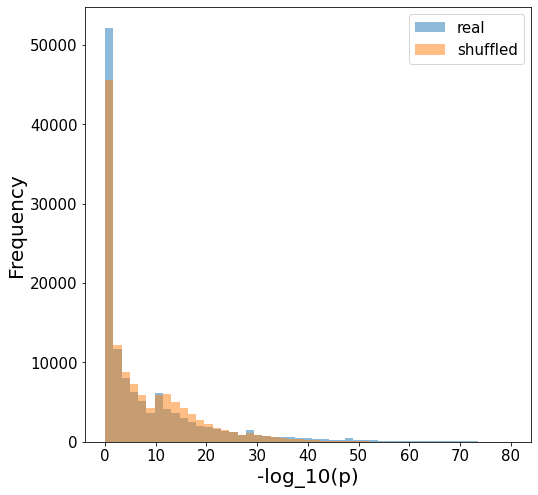

In [22]:
indices = np.triu_indices(aggregated_pvals['real'].shape[0], 1)
fig, ax = plt.subplots(1, figsize = (8,8))
for ntype in ['real','shuffled']:
    h = ax.hist(
        -np.log10(aggregated_pvals[ntype])[indices], 
        bins = np.linspace(0, 80, 50), 
        label = ntype,
        alpha = 0.5
        )

ax.tick_params(labelsize = 15)
ax.set_xlabel(f"-log_10(p)", size = 20)
ax.set_ylabel('Frequency', size = 20)
ax.legend(prop = {'size': 15})

In [109]:
THRESH = np.min(np.max(-np.log10(aggregated_pvals[ntype]), axis = 1))
adj = {ntype: -np.log10(aggregated_pvals[ntype]) for ntype in ['real','shuffled']}
for ntype in ['real','shuffled']:
    adj[ntype][adj[ntype]<THRESH] = 0
    adj[ntype][adj[ntype]>=THRESH] = 1


In [110]:
'''
phenotype_KOs = sirna[sirna['gene'].isin(lincs_genes[:numkos])].copy()
phenotype_vals = phenotype_KOs['value'].values
mygenes = phenotype_KOs['gene'].values

good_KOs = np.where([ko in mygenes for ko in lincs_genes[:numkos]])[0]
for ntype in ['real','shuffled']:
    adj[ntype] = adj[ntype][good_KOs,:]
    adj[ntype] = adj[ntype][:,good_KOs]
'''
crispr_il2 = get_crispri_il2_screen()
kos = []
vals = []
for ko, val in crispr_il2.items():
    kos.append(ko)
    vals.append(val.detach().item())
vals = np.array(vals).astype('float')

phenotype_KOs = np.where([item in lincs_genes[:numkos] for item in kos])[0]
phenotype_vals = vals[phenotype_KOs]
mygenes = [kos[idx] for idx in phenotype_KOs]

good_KOs = np.where([ko in mygenes for ko in lincs_genes[:numkos]])[0]
for ntype in ['real','shuffled']:
    adj[ntype] = adj[ntype][good_KOs,:]
    adj[ntype] = adj[ntype][:,good_KOs]

Pulling folder parsed/literature_datasets/genedisco_datasets


In [111]:
arrayed_phenotype_vals = abs(phenotype_vals[:,None] - phenotype_vals[None:])

In [119]:
np.sum(adj['real']>0)/(adj['real'].shape[0]**2)

0.05485630078256258

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa50507cf70>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa50507c460>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa50502bbe0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fa504fcbb20>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa504fcbb50>,
 'means': []}

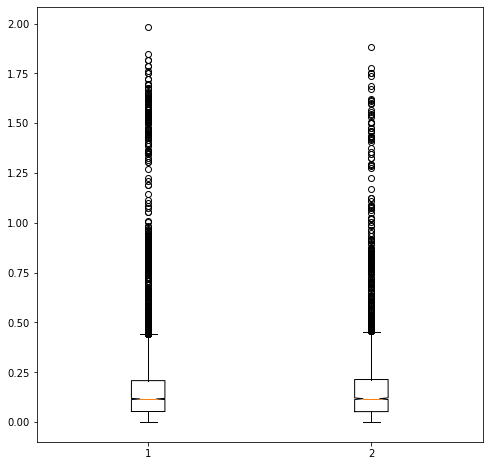

In [118]:
indices = np.triu_indices(adj['real'].shape[0],1)
boxes = [arrayed_phenotype_vals[indices][adj['real'][indices] == 1],arrayed_phenotype_vals[indices][adj['shuffled'][indices] == 1]]
fig, ax = plt.subplots(1, figsize = (8,8))
ax.boxplot(boxes, notch = True)

In [85]:
from sklearn.neighbors import KernelDensity
kde = {ntype: KernelDensity(kernel='gaussian', bandwidth=2).fit(np.stack([adj[ntype][indices],arrayed_phenotype_vals[indices]]).T) for ntype in ['real','shuffled']}

delta = 0.025
numpoints = 40
x = np.linspace(0, np.max(adj[ntype][indices]), numpoints)
y = np.linspace(0, np.max(arrayed_phenotype_vals[indices]), numpoints)
X, Y = np.meshgrid(x, y)
Z = {ntype: kde[ntype].score_samples(np.stack([X,Y]).reshape((2,numpoints**2)).T).reshape((numpoints, numpoints)) for ntype in ['real','shuffled']}


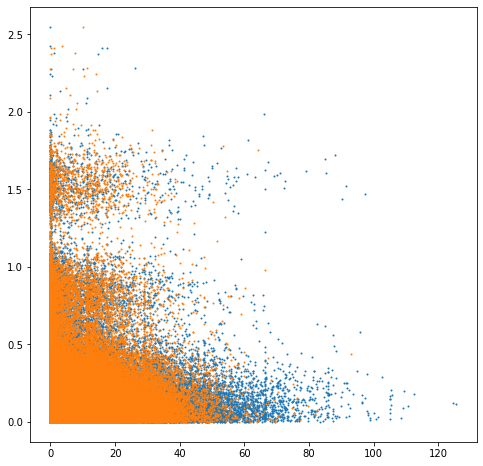

In [106]:
indices = np.triu_indices(adj['real'].shape[0],1)
fig, ax = plt.subplots(1, figsize = (8,8))
for ntype in ['real','shuffled']:
    ax.scatter(adj[ntype][indices],arrayed_phenotype_vals[indices], s= 1)

Pulling folder parsed/literature_datasets/genedisco_datasets


array([-0.04595   , -0.23472001, -0.14317   , ...,  0.090034  ,
       -0.030672  ,  0.028795  ])